This is a notebook to recap all the code used in my texxt mining final project.

# 1 Dataset creation

Need to create a dataset of competitive programming task. The dataset should include: problem_id, problem name problem description, difficulty, sample input, sample output. 

Needed: A method of extracting kattis problem informations , filtering out the sample in/out in problem description, also download .input and .ouput files.

## Fetching competitive programming problems from the open.kattis.com 

I use the python library autokattis to extract competitive programming problems from the open.kattis.com website. This website is the support for all the ICPC programming contests. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
from tqdm import tqdm
import os
from dotenv import load_dotenv
from autokattis import OpenKattis
from submit import *
from utils import *

In [1]:


load_dotenv()
user = os.getenv("USER")
password = os.getenv("PASSWORD")
print(os.getenv("TEST"))

kt = OpenKattis(user, password)

.env imported successfully
https://open.kattis.com/
[login] Candidate username(s): ['hugo-morvan']
[login] Successfully logged in to Kattis as hugo-morvan!
[database] Listed all available languages!
[database] Listed all 208 available countries!
[database] Listed all 3940 available universities!


Here is a plot showing the distribution of problem difficulty on Kattis.

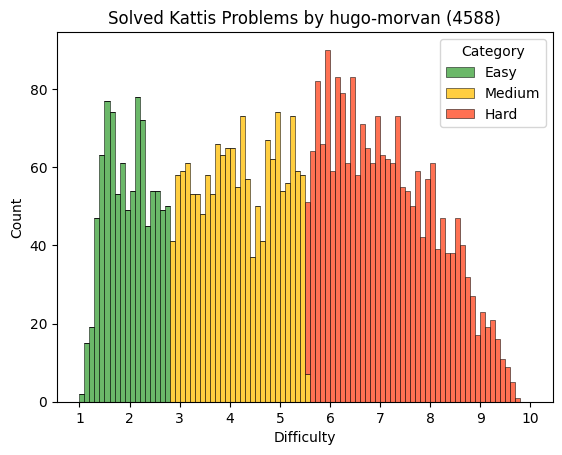

In [2]:
kt.plot_problems(show_partial=True, show_solved=True, show_tried=True, show_untried=True)

In [10]:
#Fetching all solved the problems available on the website.
problems = kt.problems(low_detail_mode=False, show_tried=True, show_untried=True) 
print(type(problems))
print(len(problems))

<class 'autokattis.api.ABCKattis.Result'>
4588


In [ ]:
df = pd.DataFrame(problems)
df.head(5)

,name,id,fastest,shortest,total,acc,difficulty,category,link
0,10 Kinds of People,10kindsofpeople,0.01,368,39937,7656,4.5,Medium,https://open.kattis.com/problems/10kindsofpeople
1,1-D Frogger (Easy),1dfroggereasy,0.00,150,10376,2029,3.2,Medium,https://open.kattis.com/problems/1dfroggereasy
2,1-D Frogger (Hard),1dfroggerhard,0.03,472,5284,477,8.1,Hard,https://open.kattis.com/problems/1dfroggerhard
3,1's For All,1sforall,0.00,5,3277,621,6.2,Hard,https://open.kattis.com/problems/1sforall
4,2048,2048,0.00,5,17428,7105,2.9,Medium,https://open.kattis.com/problems/2048


### Selection of problems for evaluation

Because trying to solve all the problems available is not feasible, we select a representative sample of problems to test the different LLM on. Ideally, the selected problems should match the distribution of problem difficulty of the whole dataset.

In [12]:
sampled_df = df.sample(n=100)

<Figure size 1500x1000 with 0 Axes>

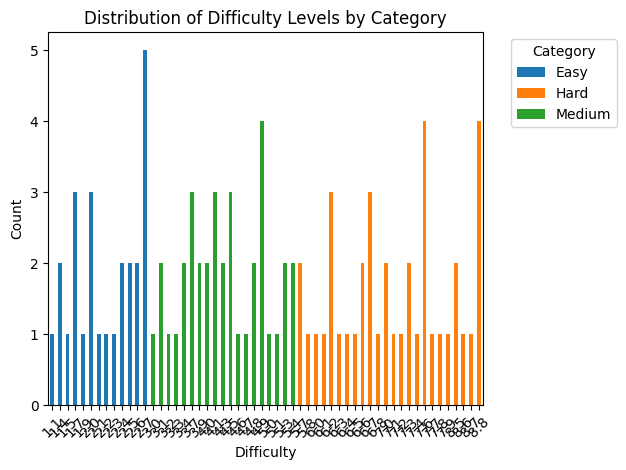

In [21]:
color_map = {'Easy': 'green','Medium': 'yellow','Hard': 'red'}
plt.figure(figsize=(15, 10))
sampled_df.groupby(['difficulty', 'category']).size().unstack().plot(kind='bar', stacked=True)
plt.title('Distribution of Difficulty Levels by Category')
plt.xlabel('Difficulty')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

The plot shows a good spread in the problem difficulty selected, however the sample size is too small to have a true representative distribution. We can now use the problem IDs to extract the problems descriptions from the same API using another function of the autokattis package.

In [22]:
# Extract problem IDs from the sampled DataFrame
problem_ids = sampled_df['id'].tolist()

# Fetch problem details using kt.problem()
problem_details = kt.problem(problem_ids)

# Extract specific details you're interested in
problem_details_extracted = []
for problem in problem_details:
    problem_details_extracted.append({
        'id': problem['id'],
        'text': problem['text'],
        'difficulty': problem.get('difficulty'),
        'category': problem.get('category'),
        'cpu_time': problem.get('cpu'),
        'memory_limit': problem.get('memory'),
        'sample_input': problem['files'].get('sample.in', '') if 'files' in problem else '',
        'sample_output': problem['files'].get('sample.ans', '') if 'files' in problem else ''
    })

# Convert to DataFrame
problem_info_df = pd.DataFrame(problem_details_extracted)

# Merge with original sampled DataFrame
combined_df = sampled_df.merge(problem_info_df, on='id')

In [ ]:
combined_df.head()

Checkpoint: saving the data to csv then reloading it. avoids running all the above when reloading the notebook.

In [24]:
combined_df.to_csv('data.csv', index=False)


In [2]:
combined_df = pd.read_csv('data.csv')
combined_df.head(5)

,name,id,fastest,shortest,total,acc,difficulty_x,category_x,link,text,difficulty_y,category_y,cpu_time,memory_limit,sample_input,sample_output
0,Emoticons,emoticons2,0.00,251,592,170,4.6,Medium,https://open.kattis.com/problems/emoticons2,Emma is a college student who regularly posts ...,4.6,Medium,3 seconds,1024 MB,NaN,NaN
1,Association for Control Over Minds,control,0.02,159,4501,1420,4.3,Medium,https://open.kattis.com/problems/control,You are the boss of ACM\n (Association for ...,4.3,Medium,4 seconds,1024 MB,NaN,NaN
2,Snapper Chain (Easy),snappereasy,0.00,5,1905,935,2.6,Easy,https://open.kattis.com/problems/snappereasy,Note that this is an easier version of the pro...,2.6,Easy,1 second,1024 MB,NaN,NaN
3,Frosh Week,froshweek2,0.01,5,3437,1772,2.2,Easy,https://open.kattis.com/problems/froshweek2,Professor Zac is trying to finish a collection...,2.2,Easy,3 seconds,1024 MB,NaN,NaN
4,99 Problems,99problems2,0.11,231,5511,4897,4.5,Medium,https://open.kattis.com/problems/99problems2,You’re creating problems for competitive\n ...,4.5,Medium,1 second,1024 MB,NaN,NaN


Some data cleaning is needed to extract problem descriptions,  expected input format, expected output format, and sample test cases. Here is a function to do just that:

In [13]:
def parse_desc(raw_text):
    """
    Given the raw text descitpion from the autokattis api response,
    return description, input_rec, output_rec, test_cases_tuples
    
    """
    splitted = raw_text.split('\n')
    try:
        input_index = splitted.index('Input')
        output_index = splitted.index('Output')
        test1 = splitted.index('Sample Input 1')
        
        description = " ".join([chunk.strip("   ") for chunk in splitted[0:input_index]])
        input_rec = " ".join([chunk.strip("   ") for chunk in splitted[input_index+1:output_index]])
        output_rec = " ".join([chunk.strip("   ") for chunk in splitted[output_index+1:test1]])
        
    except Exception: #goingincircles problem
        # no in/out requirement, its an interactive problem
        input_index = splitted.index('Interaction')
        output_index = splitted.index('Read')
        test1 = splitted.index('Read')

        description = " ".join([chunk.strip("   ") for chunk in splitted[0:input_index]])
        input_rec = " ".join([chunk.strip("   ") for chunk in splitted[input_index+1:output_index]])
        output_rec = " ".join([chunk.strip("   ") for chunk in splitted[output_index+1:test1]])
        
        
    #print(f"{output_rec=}")
    # test_cases = " ".join(splitted[test1:])
    # cleaned_test_cases = []
    # for s in test_cases.split("    "):
    #     if "Sample" in s :
    #         pass
    #     else:
    #         cleaned_test_cases.append(s)
    test_cases_tuples = []
    # for i in range(len(cleaned_test_cases)):
    #     if i%2==0:
    #         test_cases_tuples.append((cleaned_test_cases[i], cleaned_test_cases[i+1]))
    #print(f"{test_cases_tuples=}")
    return description, input_rec, output_rec, test_cases_tuples

# Testing the function:
description, input_rec, output_rec, test_cases_tuples = parse_desc(combined_df['text'][3])
print(f"{description=}")
print(f"{input_rec=}")
print(f"{output_rec=}")
print(f"{test_cases_tuples=}")

description='Professor Zac is trying to finish a collection of tasks during the first week at the start of the term. He knows precisely how long each task will take, down to the millisecond. Unfortunately, it is also Frosh Week. Zac’s office window has a clear view of the stage where loud music is played. He cannot focus on any task when music is blaring. The event organizers are also very precise. They supply Zac with intervals of time when music will not be playing. These intervals are specified by their start and end times down to the millisecond. Each task that Zac completes must be completed in one quiet interval. He cannot pause working on a task when music plays (he loses his train of thought). Interstingly, the lengths of the tasks and quiet intervals are such that it is impossible to finish more than one task per quiet interval! Given a list of times $t_ i$ (in milliseconds) that each task will take and a list of times $\\ell _ j$ (in milliseconds) specifying the lengths of th

# 2 Model evaluation

Need to create a custom evaluation for the model based on different levels of quality of the code produce by the LLM.
- Level 1: The code is written in the desired language (python) and compile without error.
- Level 2: The code can run on the test input/output without errors
- Level 3: The code succesfully solves the problem on the given sample input/output
- Level 4: The code can run on the hidden input/output withour errors
- Level 5: The code succesfully solves the hidden test cases.

Idea for evaluation: attribute points based on how many level a code generated passes. aggregate the results and rank the LLM accordingly.
To save on calculation, only evaluate level N if N-1 is validated (i.e don't bombard Kattis with non-working code. test Locally prior to testing online)

Needed : 
- A systematic method of evaluating each level. Already exists for level 5.
-> exec("code generated with {input}"), assert result = {output}


### Level 1 check: Does the code compile ?

In case of error, the type of error should be saved for statistics purposes.

In [63]:
import ast
import sys
import io
import contextlib

def check_code_compilation(code_string):
    """
    Check if the given Python code compiles without syntax errors.
    
    Args:
        code_string (str): The Python code to check for compilation
    
    Returns:
        tuple: (is_compilable, error_message)
            - is_compilable (bool): True if code compiles, False otherwise
            - error_message (str): Description of any compilation error
    """
    try:
        # First, check syntax using ast module
        ast.parse(code_string)
        
        # Redirect stderr to capture any compilation warnings
        error_output = io.StringIO()
        with contextlib.redirect_stderr(error_output):
            # Compile the code
            compiled_code = compile(code_string, '<string>', 'exec')
        
        # Check if compilation was successful
        return True, ""
    
    except SyntaxError as e:
        # Detailed syntax error reporting
        error_msg = (
            f"Syntax Error: {e.msg}\n"
            f"Line {e.lineno}, Column {e.offset}\n"
            f"Text: {e.text.strip() if e.text else 'N/A'}"
        )
        return False, error_msg
    
    except Exception as e:
        # Catch any other unexpected compilation errors
        return False, str(e)

# Example usage
def test_code_compilation():
    # Test cases
    test_cases = [
        # Compilable code
        """
def hello_world():
    print("Hello, World!")
""",
        # Code with syntax error
        """
def hello_world()
    print("Hello, World!")
""",
        # Code with indentation error
        """
def hello_world():
print("Hello, World!")
"""
    ]
    
    for code in test_cases:
        is_compilable, error_message = check_code_compilation(code)
        print(f"Code:\n{code}")
        print(f"Compilable: {is_compilable}")
        if not is_compilable:
            print(f"Error: {error_message}")
        print("-" * 40)

# Uncomment to run tests
test_code_compilation()

Code:

def hello_world():
    print("Hello, World!")

Compilable: True
----------------------------------------
Code:

def hello_world()
    print("Hello, World!")

Compilable: False
Error: Syntax Error: expected ':'
Line 2, Column 18
Text: def hello_world()
----------------------------------------
Code:

def hello_world():
print("Hello, World!")

Compilable: False
Error: Syntax Error: expected an indented block after function definition on line 2
Line 3, Column 1
Text: print("Hello, World!")
----------------------------------------


### Level 2 and 3 and check: does the code run on test cases ?

If yes, give some points. Half of problem difficulty ?
In case of error, the type of error should be saved for statistics purposes.

In [18]:
import sys
from io import StringIO
import builtins
from typing import Tuple, Optional, Union

def test_code_output(code_str: str, input_str: str, expected_output: str) -> \
    Tuple[bool, Optional[Union[str, Exception]]]:
    """
    Tests if running the provided code with given input produces the expected output.
    
    Args:
        code_str (str): The Python code to test as a string
        input_str (str): The input to provide to the code
        expected_output (str): The expected output to compare against
    
    Returns:
        Tuple[bool, Optional[Union[str, Exception]]]: 
            - First element is True if execution was successful and output matches, False otherwise
            - Second element contains:
                - None if everything is correct
                - Exception object if there was an execution error
                - String with actual output if output doesn't match expected output
    
    Example:
        code = '''
        n = int(input())
        print(n * 2)
        '''
        success, error = test_code_output(code, "5", "10")  # Returns (True, None)
    """
    # Create StringIO object for output
    output_buffer = StringIO()
    
    # Store the original stdout and input function
    original_stdout = sys.stdout
    original_input = builtins.input
    
    # Create an iterator of input lines
    input_lines = iter(input_str.splitlines())
    
    # Define mock input function
    def mock_input(*args):
        try:
            return next(input_lines)
        except StopIteration:
            raise EOFError("No more input available")
    
    try:
        # Redirect stdout and override input
        sys.stdout = output_buffer
        builtins.input = mock_input
        
        # Execute the code in a separate namespace
        namespace = {'__name__': '__main__'}
        exec(code_str, namespace)
        
        # Get the actual output and strip whitespace
        actual_output = output_buffer.getvalue().strip()
        expected_output = expected_output.strip()
        
        # Compare actual output with expected output
        if actual_output == expected_output:
            return True, None
        else:
            return False, f"WrongOutput(Expected: '{expected_output}'\nGot: '{actual_output}')"
        
    except Exception as e:
        return False, e
        
    finally:
        # Restore original stdout and input function
        sys.stdout = original_stdout
        builtins.input = original_input
        output_buffer.close()

In [20]:
# Example 1: Testing a simple doubling program
code = """
n = int(input())
print(n * 2)
"""
result = test_code_output(code, "5", "10")
print(result)  # True

# Example 2: Testing a program with incorrect output
result = test_code_output(code, "5", "11")
print(result)  # False

# Example 3: Testing a program with multiple inputs
code_multiple = """
a = input()
b = input(
print(a + b)
"""
result = test_code_output(code_multiple, "hello\nworld", "helloworld")
print(result)  # True

(True, None)
(False, "WrongOutput(Expected: '11'\nGot: '10')")
(False, SyntaxError("'(' was never closed", ('<string>', 3, 10, 'b = input(', 3, 0)))


### Level 4 and 5 and check: does the code run on test cases ?

Here we need to submit the code to the kattis website to know if the code produced passes the hidden test cases.
The Kattis CLI tool is used to do that. Only the codes that passes the level 3 should be submitted to the katti website. In case of error, the type of error should be saved for statistics purposes.

In [ ]:


#Write solution to a python file
write_solution(file_path, code)
#submit the solution to the kattis website
submit_problem(file_path , pid)

# 3 LLM Prompting

Need to create a prompt that give the description as well as sample input output to the LLM. 
Can try different methods:
- description only
- description + sample input/output
- language LLM
- Code specific LLM
- Language to Code LLM pipeline
- Different quantization methods, 
- Different model sizes.


In [33]:
#Define the different models.
generators = [0]

In [ ]:
# Connect to a kattis account

## Generate all the code solutions

In [4]:
# Qwen generator
########### Auto Solving stuff ########################
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

class QwenGenerator:
    def __init__(
        self,
        model_name: str = "Qwen/Qwen2.5-Coder-3B-Instruct",
        use_half_precision: bool = True
    ):
        # Initialize device
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        print(f"Generator running on device :{self.device}")
        # Load model with optimizations
        self.model = AutoModelForCausalLM.from_pretrained(
            model_name,
            torch_dtype=torch.float16 if use_half_precision and self.device == "cuda" else "auto",
            device_map="auto"
        )
        
        # Load tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        
        # Enable evaluation mode
        self.model.eval()
        
        # Cache for template
        self._system_message = {
            "role": "system", 
            "content": """
            You are Qwen, a highly skilled competitive python programmer. 
            When given a prompt, you only output code. 
            Your code should take in inputs using the input() function and return outputs using print().
            """
        }
        
        # Initialize CUDA graph variables if using GPU
        self.static_input_shape = None
        self.static_graph = None

    def generate_solution(self, description: str, max_new_tokens: int = 512) -> str:
        # Prepare messages
        messages = [
            self._system_message,
            {"role": "user", "content": description}
        ]
        
        # Apply template
        text = self.tokenizer.apply_chat_template(
            messages,
            tokenize=False, # Note to self: Can modify this line to test effect of description tokenization
            add_generation_prompt=True
        )
        
        # Tokenize with optimization for GPU
        with torch.inference_mode():
            model_inputs = self.tokenizer([text], return_tensors="pt").to(self.device)
            
            # Use CUDA graphs for repeated operations with same input size
            if (self.device == "cuda" and 
                (self.static_input_shape is None or 
                 self.static_input_shape != model_inputs.input_ids.shape)):
                
                self.static_input_shape = model_inputs.input_ids.shape
                torch.cuda.empty_cache()
                
                # Generate with optimized settings
                generated_ids = self._generate_optimized(model_inputs, max_new_tokens)
            else:
                generated_ids = self._generate_optimized(model_inputs, max_new_tokens)
        
        # Post-process generated IDs
        generated_ids = [
            output_ids[len(input_ids):] 
            for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
        ]
        
        # Decode and clean up response
        response = self.tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
        return response  
    
    def _generate_optimized(self, model_inputs, max_new_tokens: int):
        '''
        If you need to adjust generation speed vs quality:

        Lower temperature (e.g., 0.5) for more focused output
        Lower max_new_tokens if you don't need long responses
        Adjust top_p (e.g., 0.8) for more deterministic output  
        '''
        return self.model.generate(
            **model_inputs,
            max_new_tokens=max_new_tokens,
            pad_token_id=self.tokenizer.pad_token_id,
            eos_token_id=self.tokenizer.eos_token_id,
            use_cache=True,
            num_beams=1,        # Disable beam search for faster generation
            do_sample=True,     # Enable sampling for more natural code
            temperature=0.5,    # Add some randomness while keeping output focused
            top_p=0.95,         # Nucleus sampling to maintain code quality
        )



In [ ]:
generator = QwenGenerator()

for problem in tqdm(range(len(combined_df))):
        #print(problem)
        #name,id,fastest,shortest,total,acc,difficulty_x,category_x,link,text,
        #difficulty_y,category_y,cpu_time,memory_limit,sample_input,sample_output
        #print(combined_df['id'][problem])
        pid = combined_df['id'][problem]
        print("_"*20)
        print("_"*20)
        print(f"{pid=}")
        file_path = 'C:/Users/hugom/Documents/KattisBot/Qwen2.5-Coder-3B-Instruct/' + pid + '.py'
        if os.path.exists(file_path):
                print("File exists")
        else:
                print("File does not exist")
                #continue
                #Get the problem description, IO reqs, test IOs
                description, input_rec, output_rec, test_cases_tuples = parse_desc(combined_df['text'][problem])
                #input_str, expected_output = test_cases_tuples
                #build the prompt
                message = f"Here is the problem description: {description}.\nHere is the input description: {input_rec}.\nHere is the required output format, make sure you match it: {output_rec}"
                print(message)
                # generate code using generator and prompt
                start_time = time.time()
                raw_output = generator.generate_solution(message, 2000)
                end_time = time.time()
                runtime = end_time - start_time
                print(f"Generator time: {runtime:.4f} seconds")

                # Add delta time to statistics board.
                print("_"*20)
                print(raw_output)
                code = extract_code(raw_output)
                code = code + f"\n# Generator time: {runtime:.4f} seconds"
                print("_"*20)
                print(code)
                # write the code to a file, in a folder specific to the generator.
                
                write_solution(file_path, code)
        

Generator running on device :cuda


  0%|          | 0/100 [00:00<?, ?it/s]

____________________
____________________
pid='emoticons2'
File exists
____________________
____________________
pid='control'
File exists
____________________
____________________
pid='snappereasy'
File exists
____________________
____________________
pid='froshweek2'
File exists
____________________
____________________
pid='99problems2'
File exists
____________________
____________________
pid='gemisland'
File exists
____________________
____________________
pid='railroad'
File exists
____________________
____________________
pid='cutthenegativity'
File exists
____________________
____________________
pid='toggi'
File exists
____________________
____________________
pid='videopoker'
File exists
____________________
____________________
pid='splittingpairs'
File exists
____________________
____________________
pid='geimskip'
File exists
____________________
____________________
pid='siffersumma'
File exists
____________________
____________________
pid='hillsingothenburg'
File exists

 67%|██████▋   | 67/100 [00:17<00:08,  3.93it/s]

Generator time: 17.0589 seconds
____________________
```python
import sys
from collections import deque

def find_num_carriages():
    n = int(input())
    s = int(input())
    
    # Initialize the queue with the starting carriage
    queue = deque([0])
    visited = set([0])
    
    # Perform BFS
    while queue:
        current = queue.popleft()
        
        # Check if we have found all carriages
        if len(visited) == n:
            break
        
        # Get the state of the current carriage
        current_state = s
        
        # Explore the left and right carriages
        left = (current - 1) % n
        right = (current + 1) % n
        
        # Toggle the current carriage
        if current_state == 0:
            current_state = 1
        else:
            current_state = 0
        
        # Add the left and right carriages to the queue if they haven't been visited
        if left not in visited:
            queue.append(left)
            visited.add(left)

 68%|██████▊   | 68/100 [00:53<00:32,  1.00s/it]

Generator time: 36.1857 seconds
____________________
To solve this problem, we need to implement a function that calculates the score for each possible number of corners \( k \) (from 3 to 8) and determines which \( k \) gives the highest score. The score is calculated based on the areas of the inner and outer polygons fitted to the sample points.

Here's a step-by-step breakdown of the approach:

1. **Input Parsing**: Read the number of sample points \( n \) and the coordinates of each point.

2. **Polygon Fitting**: For each \( k \) from 3 to 8, fit a regular \( k \)-gon to the sample points:
   - **Inner Polygon**: Find the largest polygon with all vertices inside the sample points.
   - **Outer Polygon**: Find the smallest polygon with all vertices outside the sample points.

3. **Area Calculation**: Calculate the area of both the inner and outer polygons using the Shoelace formula or other suitable methods.

4. **Score Calculation**: Compute the score as \( \frac{A_{\text{inner}}}

 69%|██████▉   | 69/100 [01:15<00:49,  1.61s/it]

Generator time: 21.9105 seconds
____________________
To solve this problem, we need to determine the number of valid squares on a chessboard where no two queens can attack each other. Given the constraints, we can use a straightforward approach to check each square and see if it is safe for placing a new queen.

Here's the Python code to achieve this:

```python
def count_safe_squares(X, Y, N, queens):
    # Initialize a set to store the positions of the existing queens
    queen_positions = set()
    
    # Add the positions of the existing queens to the set
    for x, y in queens:
        queen_positions.add((x - 1, y - 1))
    
    # Initialize a counter for safe squares
    safe_count = 0
    
    # Iterate over each possible square on the board
    for x in range(X):
        for y in range(Y):
            # Check if the current square is not occupied and not on the same row, column, or diagonal
            if (x, y) not in queen_positions:
                safe = True
             

 70%|███████   | 70/100 [01:19<00:51,  1.71s/it]

Generator time: 4.1825 seconds
____________________
```python
from math import comb

def count_multiples_of_k(N, K):
    count = 0
    for i in range(N + 1):
        for j in range(i + 1):
            if comb(i, j) % K == 0:
                count += 1
    return count

# Read input
N, K = map(int, input().split())

# Compute and print the result
print(count_multiples_of_k(N, K))
```
____________________
from math import comb

def count_multiples_of_k(N, K):
    count = 0
    for i in range(N + 1):
        for j in range(i + 1):
            if comb(i, j) % K == 0:
                count += 1
    return count

# Read input
N, K = map(int, input().split())

# Compute and print the result
print(count_multiples_of_k(N, K))
# Generator time: 4.1825 seconds
____________________
____________________
pid='jointexcavation'
File does not exist
Here is the problem description: Mole by Ahmad Kanbar, Unsplash  The mole family recently decided to dig a new tunnel network. The layout, which has already

 71%|███████   | 71/100 [01:38<01:16,  2.63s/it]

Generator time: 18.6967 seconds
____________________
```python
from collections import defaultdict, deque

def find_path_and_divide(chambers, tunnels):
    # Build the graph
    graph = defaultdict(list)
    for a, b in tunnels:
        graph[a].append(b)
        graph[b].append(a)

    # Find the cycle
    def dfs(node, parent, visited):
        visited[node] = True
        for neighbor in graph[node]:
            if not visited[neighbor]:
                if dfs(neighbor, node, visited):
                    return True
            elif neighbor != parent:
                return True
        return False

    visited = [False] * (chambers + 1)
    cycle_start = None
    for i in range(1, chambers + 1):
        if not visited[i]:
            if dfs(i, None, visited):
                cycle_start = i
                break

    if cycle_start is None:
        print("0 0")
        return

    # Find the path in the cycle
    path = []
    current = cycle_start
    visited = [False] * (chamb

 72%|███████▏  | 72/100 [01:56<01:45,  3.77s/it]

Generator time: 18.7293 seconds
____________________
To solve this problem, we need to compute the length of the Farey Sequence of order \( N \). The Farey Sequence of order \( N \) is the sequence of all fractions \( \frac{a}{b} \) with \( 0 \le a \le b \), \( 1 \le b \le N \), and \( a \) and \( b \) relatively prime, listed in increasing order.

Here's a Python program that implements this:

```python
from math import gcd

def farey_sequence_length(N):
    count = 1  # Start with 0/1
    a, b = 0, 1
    while True:
        next_a = a + b
        next_b = b
        if next_b > N:
            break
        if gcd(next_a, next_b) == 1:
            count += 1
        a, b = next_a, next_b
    return count

def main():
    P = int(input())
    for _ in range(P):
        K, N = map(int, input().split())
        length = farey_sequence_length(N)
        print(f"{K} {length}")

if __name__ == "__main__":
    main()
```

### Explanation:

1. **Function `farey_sequence_length(N)`**:
   - This

 73%|███████▎  | 73/100 [02:18<02:26,  5.44s/it]

Generator time: 21.8566 seconds
____________________
To solve this problem, we need to determine the maximum number of rhombinoes that can be placed on a given Rhombino board. A rhombino covers two adjacent live triangles that share a common side. Here's a step-by-step approach to solve this problem:

1. **Parse the Input**: Read the dimensions of the board and the coordinates of the dead triangles.
2. **Initialize the Board**: Create a grid to represent the board, marking the live and dead triangles.
3. **Count Live Triangles**: Calculate the number of live triangles on the board.
4. **Calculate Maximum Rhombinoes**: Since each rhombino covers two adjacent live triangles, the maximum number of rhombinoes that can be placed is half the number of live triangles, rounded down to the nearest integer.

Here's the Python code implementing the above logic:

```python
def max_rhombinoes(W, H, K, dead_triangles):
    # Initialize the board with all live triangles
    board = [[True] * H for _ 

 74%|███████▍  | 74/100 [02:44<03:23,  7.81s/it]

Generator time: 25.7375 seconds
____________________
To solve this problem, we need to determine the positions of Agneta and Beata as functions of time \( t \) and then calculate their Euclidean distance at each time step. Here's the step-by-step approach:

1. **Position Calculation**:
   - Agneta's position on her slide can be described by polar coordinates \((r_A, \theta_A)\), where \( r_A = 1 \) (radius) and \(\theta_A = \omega_A t\) (angle), with \(\omega_A = 1 \text{ rad/s}\).
   - Beata's position on her slide can be described by polar coordinates \((r_B, \theta_B)\), where \( r_B = 1 \) (radius) and \(\theta_B = \omega_B t\), with \(\omega_B = 2 \text{ rad/s}\).

2. **Convert Polar to Cartesian Coordinates**:
   - For Agneta: \( x_A = r_A \cos(\theta_A) = \cos(\theta_A) \)
   - For Beata: \( x_B = r_B \cos(\theta_B) = \cos(\theta_B) \)

3. **Calculate Euclidean Distance**:
   - The Euclidean distance \( d(t) \) between Agneta and Beata at time \( t \) is given by:
     \[
     d

 75%|███████▌  | 75/100 [03:24<05:08, 12.35s/it]

Generator time: 39.6160 seconds
____________________
To solve this problem, we need to simulate the movement of the kayaker through the cave system as the water level decreases. We'll use a breadth-first search (BFS) approach to find the shortest path from the starting point to the exit point, taking into account the constraints on moving through the caves and the time it takes to move based on the water level.

Here's the Python code to solve the problem:

```python
from collections import deque

def bfs(start, end, grid, H):
    N, M = len(grid), len(grid[0])
    
    # Directions for moving up, down, left, right
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    
    # Queue for BFS
    queue = deque([(start[0], start[1], 0)])
    visited = set()
    
    while queue:
        x, y, time = queue.popleft()
        
        # If we reach the exit, return the time taken
        if (x, y) == end:
            return time
        
        # Check if the current position is already vis

 76%|███████▌  | 76/100 [03:37<04:59, 12.48s/it]

Generator time: 13.0883 seconds
____________________
To solve this problem, we need to determine the maximum possible score you could have gotten by comparing your answers with your friend's answers. Here's a step-by-step approach to achieve this:

1. **Parse the Input**: Read the number of correct answers (`k`), your answers (`your_answers`), and your friend's answers (`friend_answers`).

2. **Calculate Maximum Possible Score**:
   - Since you know your answers, you can maximize your score by matching as many of your answers as possible with your friend's answers.
   - The maximum score you can get is the sum of the number of correct answers (`k`) and the number of questions where your answer matches your friend's answer.

3. **Output the Result**: Print the maximum possible score.

Here's the Python code implementing the above logic:

```python
# Read input
k = int(input())
your_answers = input()
friend_answers = input()

# Calculate the maximum possible score
max_score = k + sum(1 f

 77%|███████▋  | 77/100 [04:05<05:56, 15.51s/it]

Generator time: 28.0092 seconds
____________________
To solve this problem, we need to determine if it's possible to construct a simple rectilinear polygon with the given points as vertices. A rectilinear polygon is one where all edges are either horizontal or vertical, and each vertex is an endpoint of exactly one horizontal and one vertical edge.

Here's a step-by-step approach to solve the problem:

1. **Input Parsing**: Read the number of test cases and for each test case, read the number of points `n` and their coordinates.

2. **Sort Points**: Sort the points based on their x-coordinates and then by their y-coordinates. This helps in easily forming a rectilinear polygon by connecting consecutive points horizontally and vertically.

3. **Check Feasibility**: For each test case, check if it's possible to form a rectilinear polygon by connecting the sorted points. This can be done by ensuring that:
   - No two points have the same x-coordinate.
   - No two points have the same y-coo

 78%|███████▊  | 78/100 [04:43<07:32, 20.56s/it]

Generator time: 38.7058 seconds
____________________
```python
import sys
from math import sqrt

def polygon_area(vertices):
    n = len(vertices)
    area = 0.0
    for i in range(n):
        j = (i + 1) % n
        area += vertices[i][0] * vertices[j][1]
        area -= vertices[j][0] * vertices[i][1]
    area = abs(area) / 2.0
    return area

def point_in_polygon(point, polygon):
    n = len(polygon)
    inside = False
    p1x, p1y = polygon[0]
    for i in range(n + 1):
        p2x, p2y = polygon[i % n]
        if point[1] > min(p1y, p2y):
            if point[1] <= max(p1y, p2y):
                if point[0] <= max(p1x, p2x):
                    if p1y != p2y:
                        xints = (point[1] - p1y) * (p2x - p1x) / (p2y - p1y) + p1x
                    if p1x == p2x or point[0] <= xints:
                        inside = not inside
        p1x, p1y = p2x, p2y
    return inside

def closest_point_on_line(p1, p2, point):
    x1, y1 = p1
    x2, y2 = p2
    dx, dy = x2 - x1, 

 79%|███████▉  | 79/100 [04:46<05:40, 16.21s/it]

Generator time: 2.2492 seconds
____________________
```python
# Read the input word and the number of repetitions
word = input()
repetitions = int(input())

# Print the word repeated the specified number of times
print(word * repetitions)
```
____________________
# Read the input word and the number of repetitions
word = input()
repetitions = int(input())

# Print the word repeated the specified number of times
print(word * repetitions)
# Generator time: 2.2492 seconds
____________________
____________________
pid='doors'
File does not exist
Here is the problem description: Alex is a circle of radius $R$. Well, life as a circle is not easy. If he were a point, moving around and passing through doors would be effortless. But now he has to carefully inspect the surroundings before making every move.      Alex’s is initially at position $(0, y_\infty )$, where $y_\infty $ is much bigger than the width of the corridor $w$. Alex wants to meet Bob, who happens to be living to the far right o

 80%|████████  | 80/100 [05:28<07:37, 22.86s/it]

Generator time: 42.4658 seconds
____________________
To solve this problem, we need to determine the maximum radius \( r \) such that Alex can reach Bob while avoiding the walls and doors. Given the constraints and the nature of the problem, we can use geometric reasoning and optimization techniques.

Here's a step-by-step approach to solve the problem:

1. **Understand the Geometry**: 
   - Alex starts at \((0, y_\infty)\).
   - Bob is at \((x_\infty, w/2)\).
   - The doors are along the x-axis with lengths \(\ell\) and starting at positions \(x_1\) and \(x_2\).

2. **Define the Problem**:
   - We need to find the largest \( r \leq R \) such that there exists a continuous curve from \((0, y_\infty)\) to \((x_\infty, w/2)\) that avoids the walls and doors.
   - The minimal distance between any point on the curve and an obstacle must be at least \( r \).

3. **Approach**:
   - Use numerical methods to check different values of \( r \) and determine if a valid path exists.
   - We can us

 81%|████████  | 81/100 [05:58<07:51, 24.83s/it]

Generator time: 30.2729 seconds
____________________
To solve this problem, we need to calculate the visible area of each building from a given perspective. Since the buildings are assumed to be trapezoids with vertical walls and a sloping roof, we can use geometric calculations to determine the visible area.

Here's a step-by-step approach to solve the problem:

1. **Input Parsing**: Read the number of buildings and their coordinates.
2. **Visibility Calculation**: For each building, calculate the visible area by considering the overlap with other buildings.
3. **Output**: Print the visible area for each building.

Here's the Python code implementing the above logic:

```python
import math

def visible_area(x1, y1, x2, y2):
    # Calculate the area of the trapezoid
    base1 = x2 - x1
    height = y2 - y1
    area = 0.5 * (base1 + height) * height
    
    # Calculate the visible area
    # We need to consider the overlap with other buildings
    # For simplicity, we assume that the b

 82%|████████▏ | 82/100 [06:27<07:44, 25.82s/it]

Generator time: 28.4210 seconds
____________________
To solve this problem, we need to find the optimal bridge that minimizes the total distance between all pairs of lovers. The optimal bridge is one where the sum of the distances between each pair of lovers is minimized. Here's a step-by-step approach to achieve this:

1. **Parse the Input**: Read the input values for \( N \), \( M \), and the height array \( H \). Also, read the pairs of positions for each lover.

2. **Sort the Heights**: Sort the heights array \( H \) to facilitate the process of finding the optimal bridge.

3. **Find the Optimal Bridge**:
   - Iterate through the sorted heights array to find the longest increasing subsequence (LIS) of heights.
   - The LIS will help us determine the optimal bridge because the bridge will connect the longest increasing sequence of heights.

4. **Calculate the Total Distance**:
   - For each pair of lovers, calculate the distance between their positions using the height differences.


 83%|████████▎ | 83/100 [06:31<05:37, 19.87s/it]

Generator time: 4.7168 seconds
____________________
```python
# Read input values
N = int(input())
a, b = map(int, input().split())

# Calculate XOR of numbers from a to b
result = 0
for i in range(a, b + 1):
    result ^= i

# Determine the output based on the result
if result == 0:
    print("Enginn")
elif result <= N:
    print(result)
else:
    print("Gunnar")
```
____________________
# Read input values
N = int(input())
a, b = map(int, input().split())

# Calculate XOR of numbers from a to b
result = 0
for i in range(a, b + 1):
    result ^= i

# Determine the output based on the result
if result == 0:
    print("Enginn")
elif result <= N:
    print(result)
else:
    print("Gunnar")
# Generator time: 4.7168 seconds
____________________
____________________
pid='screen'
File does not exist
Here is the problem description: The ZOO management had been wondering for a long time how to increase the number of children visitors to the ZOO. The solution was surprising and unexpected in ma

 84%|████████▍ | 84/100 [06:57<05:45, 21.59s/it]

Generator time: 25.8519 seconds
____________________
```python
import sys
from math import sqrt

def parse_formula(formula):
    lines = formula.split('\n')
    R, C = len(lines), len(lines[0])
    
    def parse_term(line, start):
        end = start
        while end < C and line[end].isdigit():
            end += 1
        term = int(line[start:end])
        if end < C and line[end] == '*':
            end += 1
            term *= parse_term(line, end)
        return term
    
    def parse_simple(line, start):
        end = start
        while end < C and line[end].isdigit():
            end += 1
        simple = parse_term(line, start)
        if end < C:
            if line[end] == '+':
                end += 1
                simple += parse_simple(line, end)
            elif line[end] == '-':
                end += 1
                simple -= parse_simple(line, end)
        return simple
    
    def parse_sqrt(line, start):
        end = start
        while end < C and line[en

 85%|████████▌ | 85/100 [07:28<06:04, 24.30s/it]

Generator time: 30.9097 seconds
____________________
To solve this problem, we need to determine the minimum number of instructions required to execute a given program on a Harvard architecture microcontroller with a specified number of memory banks and variables per bank. The key is to efficiently map variables to memory banks and minimize the number of BSR register settings.

Here's a step-by-step breakdown of the solution:

1. **Input Parsing**: Read the input values for the number of memory banks `b` and the number of variables per bank `s`. Then read the program as a list of operations.

2. **Program Execution Plan**:
   - We need to map each variable reference to a specific bank and offset.
   - We also need to track the current state of the BSR register.
   - We will iterate through the program, updating the BSR and memory bank mappings as needed.

3. **Mapping Variables to Banks**:
   - Use a dictionary to map each variable to a bank and offset.
   - Ensure that no two variable

 86%|████████▌ | 86/100 [07:50<05:29, 23.51s/it]

Generator time: 21.6190 seconds
____________________
To solve this problem, we need to determine the minimum number of mutations required to transform a given DNA sequence consisting of 'A's into a sequence of 'B's. There are two types of mutations:

1. **Single Character Mutation**: Changes any single character from 'A' to 'B' or from 'B' to 'A'.
2. **Prefix Mutation**: Changes all characters in positions from 1 to \( K \) to the opposite character, where \( K \) is some integer between 1 and \( N \).

The goal is to find the minimum number of mutations needed to achieve the transformation.

### Approach

1. **Count 'B's in the Sequence**: First, count the number of 'B's in the initial sequence. This gives us the number of mutations needed if we were to change all 'A's to 'B's one by one.

2. **Consider Prefix Mutations**: For each possible prefix mutation, calculate how many 'A's remain after applying the mutation. If the number of remaining 'A's is less than the total number of 'A's

 87%|████████▋ | 87/100 [08:18<05:22, 24.82s/it]

Generator time: 27.9209 seconds
____________________
To solve this problem, we need to determine if it's possible to arrange the numbers from 1 to \( N \) in a way that forms a histogram with a capacity of exactly \( X \). The capacity of a histogram is defined as the maximum amount of water it can hold while remaining stable.

Here's a step-by-step approach to solve the problem:

1. **Understand the Constraints**: We need to ensure that the histogram is stable and that the total capacity is exactly \( X \).

2. **Stability Condition**: For a histogram to be stable, the height of the water above each column must satisfy the conditions:
   - \( h_i + v_i \leq h_{i-1} + v_{i-1} \) for \( i > 2 \) if \( v_i > 0 \)
   - \( h_i + v_i \leq h_{i+1} + v_{i+1} \) for \( i \leq N - 1 \) if \( v_i > 0 \)
   - \( v_1 = 0 \) and \( v_N = 0 \)

3. **Capacity Calculation**: The capacity of the histogram is the sum of the heights of the water above each column, i.e., \( \sum_{i=1}^N v_i \).

4. **Appr

 88%|████████▊ | 88/100 [08:42<04:54, 24.55s/it]

Generator time: 23.9022 seconds
____________________
To solve this problem, we need to count the number of binary strings of length \( n \) that do not contain the substring "11". We can use dynamic programming to efficiently compute this.

Let's define:
- \( dp[i] \) as the number of valid binary strings of length \( i \).

The transitions between states can be described as follows:
- If the last character of a valid string of length \( i \) is '0', then the previous character can be either '0' or '1'.
- If the last character of a valid string of length \( i \) is '1', then the previous character must be '0' to avoid the substring "11".

We can use these transitions to build up our solution iteratively.

Here's the Python code to implement this:

```python
def count_valid_binary_strings(n):
    MOD = 10**9 + 7
    
    # Base cases
    if n == 1:
        return 2  # "0" and "1"
    if n == 2:
        return 3  # "00", "01", "10"
    
    # Initialize dp array
    dp = [0] * (n + 1)
  

 89%|████████▉ | 89/100 [08:44<03:17, 17.93s/it]

Generator time: 2.3146 seconds
____________________
```python
while True:
    try:
        line = input()
        if 'problem' in line.lower():
            print('yes')
        else:
            print('no')
    except EOFError:
        break
```
____________________
while True:
    try:
        line = input()
        if 'problem' in line.lower():
            print('yes')
        else:
            print('no')
    except EOFError:
        break
# Generator time: 2.3146 seconds
____________________
____________________
pid='boi23.staringcontest'
File does not exist
Here is the problem description: A staring contest is a classical battle of imperturbability in which two people stare into each other’s eyes while maintaining a facial expression of assured serenity. The goal is to maintain eye contact for longer than your opponent. The contest ends when one participant breaks composure, typically by looking away, smiling, speaking, or giggling. As a coach of the national staring contest you n

 90%|█████████ | 90/100 [08:57<02:44, 16.40s/it]

Generator time: 12.8114 seconds
____________________
```python
import sys

def main():
    n = int(input())
    queries = []
    
    # Generate all possible pairs of athletes
    for i in range(n):
        for j in range(i + 1, n):
            queries.append((i, j))
    
    # Perform queries and store results
    results = {}
    for i, j in queries:
        result = int(input("? {} {}".format(i + 1, j + 1)))
        results[(i, j)] = result
    
    # Calculate the estimated strengths
    estimates = [0] * n
    for i in range(n):
        for j in range(i + 1, n):
            if (i, j) in results:
                estimates[i] = max(estimates[i], results[(i, j)])
                estimates[j] = max(estimates[j], results[(i, j)])
    
    # Output the estimates
    print("! ", end="")
    for b in estimates:
        print(b, end=" ")
    print()

if __name__ == "__main__":
    main()
```

This Python script simulates the process of determining the imperturbability of each athlete in th

 91%|█████████ | 91/100 [09:29<03:10, 21.15s/it]

Generator time: 32.2786 seconds
____________________
To solve this problem, we need to simulate the process of dropping paint onto the canvas and determining the final color at each query point. Here's a step-by-step approach to implement this:

1. **Parse the Input**: Read the number of paintings, the details of each painting (number of drops, drop locations and volumes, and their colors), and then read the queries.

2. **Simulate Paint Dropping**: For each painting, simulate the dropping of each drop onto the canvas. Update the color of the canvas at each point where the drop spreads out.

3. **Query the Canvas**: For each query, determine the color of the paint at the specified point on the canvas.

4. **Output the Results**: Print the color for each query.

Here's the Python code implementing the above logic:

```python
import math

def get_color(x, y, color):
    # Return the color as a string
    return color

def drop_paint(canvas, x, y, v):
    # Calculate the radius of the pai

 92%|█████████▏| 92/100 [10:13<03:42, 27.87s/it]

Generator time: 43.6047 seconds
____________________
To solve this problem, we need to find the smallest convex polygon \( Z \) that contains all \( K \) sightings of Celery inside it. This problem can be approached using the concept of the Convex Hull, which is a well-known algorithm for finding the smallest convex polygon that encloses a set of points.

Here's a step-by-step outline of the approach:

1. **Input Reading**: Read the number of vertices \( N \) and the coordinates of the vertices of the convex polygon \( A \). Then read the number of sightings \( K \) and the coordinates of the sightings.

2. **Convex Hull Calculation**: Use the Graham Scan algorithm to compute the convex hull of the points in \( A \). The Graham Scan algorithm is efficient and works in \( O(N \log N) \) time.

3. **Check Each Subset**: For each subset of vertices from the convex hull, check if all \( K \) sightings are inside the polygon formed by these vertices. This can be done using the point-in-poly

 93%|█████████▎| 93/100 [10:15<02:21, 20.22s/it]

Generator time: 2.3156 seconds
____________________
```python
# Read two integers from the input
a = int(input())
b = int(input())

# Calculate the sum of the two integers
result = a + b

# Print the result
print(result)
```
____________________
# Read two integers from the input
a = int(input())
b = int(input())

# Calculate the sum of the two integers
result = a + b

# Print the result
print(result)
# Generator time: 2.3156 seconds
____________________
____________________
pid='greedypolygons2'
File does not exist
Here is the problem description: MAPS 2020 included a problem named “Greedy Polygons” that described a dystopian world in which the greed that often characterizes human nature had spread to regular polygons, causing these normally well-behaved shapes to exhibit expansionistic tendencies. Now, as feared, this avarice has advanced further, infecting all convex polygons. In the past, the area of a convex polygon was fixed, but now, whenever it gets the chance, a convex polygon

 94%|█████████▍| 94/100 [10:45<02:19, 23.23s/it]

Generator time: 30.2785 seconds
____________________
To solve the problem of calculating the area of a convex polygon after a specified number of land grabs, we need to follow these steps:

1. **Read the Input**: Parse the input to get the number of vertices `n`, the expansion distance `d`, and the number of land grabs `g`. Also, read the coordinates of the polygon vertices.

2. **Calculate Initial Area**: Use the Shoelace formula to calculate the area of the initial convex polygon.

3. **Simulate Land Grabs**: For each land grab, update the polygon by including all points within a distance `d` of any point in the polygon. This can be done by checking each point in the plane and determining if it is within the expanded region.

4. **Calculate New Area**: After each land grab, use the Shoelace formula again to calculate the new area of the polygon.

5. **Output the Result**: Print the area of the polygon after `g` land grabs.

Here's the Python code implementing the above logic:

```pyt

 95%|█████████▌| 95/100 [11:11<01:59, 23.83s/it]

Generator time: 25.2273 seconds
____________________
```python
def calculate_moves(maze):
    R, C = len(maze), len(maze[0])
    goal = None

    # Find the goal position
    for r in range(R):
        for c in range(C):
            if maze[r][c] == 'M':
                goal = (r, c)
                break
        if goal:
            break

    if not goal:
        return [[-1] * C for _ in range(R)]

    # Directions: up, down, left, right
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

    # Initialize the distance matrix with infinity
    distance = [[float('inf')] * C for _ in range(R)]
    distance[goal[0]][goal[1]] = 0

    queue = [(goal[0], goal[1])]

    while queue:
        current_r, current_c = queue.pop(0)

        for dr, dc in directions:
            new_r, new_c = current_r + dr, current_c + dc

            # Check if the new position is within bounds
            if 0 <= new_r < R and 0 <= new_c < C:
                # Check if the new position is an obstacle
      

 96%|█████████▌| 96/100 [11:25<01:24, 21.04s/it]

Generator time: 14.5155 seconds
____________________
```python
from math import gcd

def count_cp_sequences(S):
    def is_valid_sequence(sequence):
        if len(sequence) == 1:
            return True
        
        ratio = sequence[1] / sequence[0]
        for i in range(1, len(sequence)):
            if sequence[i] / sequence[i - 1] != ratio:
                return False
            if gcd(sequence[i], sequence[i - 1]) != 1:
                return False
        return True

    def find_sequences(S, current_sequence, index):
        if sum(current_sequence) == S:
            if is_valid_sequence(current_sequence):
                sequences.append(current_sequence[:])
            return
        if sum(current_sequence) > S or index >= len(numbers):
            return

        for i in range(index, len(numbers)):
            current_sequence.append(numbers[i])
            find_sequences(S, current_sequence, i + 1)
            current_sequence.pop()

    numbers = list(range(1, S +

 97%|█████████▋| 97/100 [11:48<01:05, 21.73s/it]

Generator time: 23.3455 seconds
____________________
To solve this problem, we need to calculate the probability that all \( p \) people in your group will be among the \( n \) lucky winners. Each winner can buy up to \( t \) tickets, but since we are only interested in whether they are in the group or not, we can simplify the problem by considering the probability that all \( p \) people are among the \( n \) winners.

Here's the step-by-step approach:

1. **Calculate the total number of ways to choose \( n \) winners out of \( m \):**
   \[
   \binom{m}{n}
   \]

2. **Calculate the number of favorable outcomes where all \( p \) people are among the \( n \) winners:**
   - Choose \( p \) people from your group to be the winners. This can be done in:
     \[
     \binom{p}{p} = 1
     \]
   - The remaining \( n - p \) winners must be chosen from the remaining \( m - p \) people. This can be done in:
     \[
     \binom{m-p}{n-p}
     \]

3. **Calculate the probability:**
   The probabi

 98%|█████████▊| 98/100 [12:12<00:44, 22.40s/it]

Generator time: 23.9613 seconds
____________________
To solve this problem, we need to determine the minimum cost to store \( K \) bytes of data using storage servers of the same size. The cost of purchasing \( M \) servers of size \( M \) is \( M + M = 2M \). To minimize the cost, we need to find the optimal \( M \) such that \( M \) divides \( K \) and minimizes \( 2M \).

Here's the step-by-step approach:

1. **Parse the Input**: Read the input string representing the prime factorization of \( K \).
2. **Factorize \( K \)**: Convert the string into a list of prime factors.
3. **Calculate Possible Server Sizes**: For each prime factor \( p \), calculate possible server sizes \( M \) such that \( K = M \times n \) where \( n \) is an integer.
4. **Find the Minimum Cost**: For each possible \( M \), calculate the cost \( 2M \) and keep track of the minimum cost.

Here's the Python code implementing the above approach:

```python
def min_cost_to_store(K):
    # Parse the input string
  

 99%|█████████▉| 99/100 [12:43<00:24, 24.79s/it]

Generator time: 30.3789 seconds
____________________
To solve this problem, we need to assign each citizen to the train line with the least angular distance from their home, while ensuring that no train line exceeds its capacity. Here's a step-by-step approach to achieve this:

1. **Calculate Angular Distances**: For each citizen, calculate the angle of the vector from the central hub to their home. This can be done using the arctangent function.

2. **Sort Citizens by Angle**: Sort the citizens based on their calculated angles. If two citizens have the same angle, sort them by the x-coordinate (or y-coordinate, depending on the preference).

3. **Assign Citizens to Trains**: Iterate through the sorted list of citizens and assign each one to the train line with the least angular distance. If a train line reaches its capacity, move on to the next one.

4. **Output the Results**: Print the number of citizens who went by train and their respective assignments.

Here's the Python code impl

100%|██████████| 100/100 [12:54<00:00,  7.74s/it]

Generator time: 10.9998 seconds
____________________
```python
import sys
input = sys.stdin.read
data = input().split()

n = int(data[0])
k = int(data[1])

samples = [data[i] for i in range(2, 2 + n)]

def hamming_distance(s1, s2):
    return sum(c1 != c2 for c1, c2 in zip(s1, s2))

def build_tree(samples):
    if len(samples) == 1:
        return 0, []
    
    min_unlikeliness = float('inf')
    best_edges = []
    
    for i in range(len(samples)):
        for j in range(i + 1, len(samples)):
            distance = hamming_distance(samples[i], samples[j])
            current_unlikeliness = distance + build_tree([samples[i]])[0] + build_tree([samples[j]])[0]
            
            if current_unlikeliness < min_unlikeliness:
                min_unlikeliness = current_unlikeliness
                best_edges = [(i, j)]
    
    return min_unlikeliness, best_edges

min_unlikeliness, edges = build_tree(samples)

print(min_unlikeliness)
for edge in edges:
    print(edge[0], edge[1])
```


## Test all the code generated:


In [ ]:
#Generate code from the different model (generators), and test it.


for problem in range(len(combined_df)):

    pid = combined_df['id'][problem]
    
    file_path = 'C:/Users/hugom/Documents/KattisBot/Qwen2.5-Coder-3B-Instruct/' + pid + '.py'
    code = ""
    with open(file_path, 'r', encoding='utf-8') as code:
    
        # Test the different level:

        # Level 1: Code compiles:
        level1 = check_code_compilation(code)
        # If the code does not pass level 1, continue to next problem (saves computation)
        if not level1: continue

        # Level 2, 3: Code run and solve test IO
        lvl2_list = []
        lvl3_list = []
        for test_case in range(len(input_str)):
            test_res, errors = test_code_output(code, input_str[test_case], expected_output[test_case])
            if test_res: #Code sucessfully passed level 2 and 3
                lvl2_list.append(True)
                lvl3_list.append(True)
            else: #Code did not run successfully, is error level 2 (run time error) or level 3 (wrong output)
                if "WrongOutput" in errors: #level 3 error
                    lvl2_list.append(True)
                    lvl3_list.append(False)
                else: #Run time error
                    lvl2_list.append(False)
                    lvl3_list.append(False)
                    
        # Did the code run without error on all the test cases?
        level2 = all(lvl2_list)
        # Did the code pass all the test cases ? 
        level3 = all(lvl3_list)
        
        # If the code does not pass level 3, continue to next problem (saves computation)
        if not level3: continue
        
        # Level 4, 5: Code run and solve hidden IO (Only run if level 3 passes)
        continue #DON'T RUN ON KATTIS YET
        kattis_response = submit_problem(file_path, pid)
        if "Accepted" in kattis_response:
            level4 = True
            level5 = True
        elif "Wrong Answer" in kattis_response:
            level4 = True
            level5 = False
        else:
            level4 = False
            level5 = False
            # obtain the type of error for statistics
        
        # Output problem level statistics

    
# Done
        file_path = file_path = 'C:/Users/hugom/Documents/KattisBot/Qwen2.5-Coder-3B-Instruct/' + pid + '.py'      

## Results

After all this work, here comes the results:

TBD